In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
file = 'filtered_data.csv'
df = pd.read_csv(file)

In [3]:
print("First 5 rows of the dataset:")
display(df.head())

First 5 rows of the dataset:


,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,Male,40,165,75,91.0,1.2,1.5,1.0,1.0,120.0,...,74.0,104.0,15.8,1.0,0.9,47.0,32.0,68.0,1.0,N
1,Male,50,175,80,91.0,1.5,1.2,1.0,1.0,145.0,...,104.0,106.0,17.6,1.0,1.1,29.0,34.0,18.0,1.0,N
2,Male,50,165,60,80.0,1.0,1.2,1.0,1.0,138.0,...,117.0,104.0,13.8,1.0,0.8,19.0,12.0,25.0,1.0,N
3,Male,50,165,55,75.0,1.2,1.5,1.0,1.0,142.0,...,95.0,232.0,13.8,3.0,0.8,29.0,40.0,37.0,3.0,Y
4,Female,45,150,55,69.0,0.5,0.4,1.0,1.0,101.0,...,115.0,75.0,12.3,1.0,0.8,19.0,12.0,12.0,1.0,N


Summary Statistics

In [4]:
display(df.describe())

,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,DBP,...,HDL_chole,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd
count,595460.000000,595460.000000,595460.000000,595460.000000,595460.000000,595460.000000,595460.000000,595460.000000,595460.000000,595460.000000,...,595460.000000,595460.000000,595460.000000,595460.000000,595460.000000,595460.000000,595460.000000,595460.000000,595460.000000,595460.000000
mean,49.531656,161.829594,63.205975,81.238440,0.984240,0.981437,1.022012,1.021271,122.461510,76.805532,...,56.819934,116.761734,137.548368,14.215767,1.091724,0.851967,26.547704,26.265667,39.760392,1.626700
std,7.009128,8.679070,11.778739,9.269496,0.544064,0.538165,0.146721,0.144286,14.289306,9.974158,...,15.046802,36.052788,105.251340,1.581717,0.431582,0.486496,26.584648,26.559756,54.936772,0.817538
min,40.000000,135.000000,30.000000,32.000000,0.100000,0.100000,1.000000,1.000000,67.000000,32.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.100000,1.000000,1.000000,1.000000,1.000000
25%,45.000000,155.000000,55.000000,75.000000,0.800000,0.800000,1.000000,1.000000,112.000000,70.000000,...,46.000000,93.000000,77.000000,13.200000,1.000000,0.700000,19.000000,15.000000,16.000000,1.000000
50%,50.000000,160.000000,60.000000,81.000000,1.000000,1.000000,1.000000,1.000000,121.000000,77.000000,...,55.000000,115.000000,111.000000,14.200000,1.000000,0.800000,23.000000,21.000000,24.000000,1.000000
75%,55.000000,170.000000,70.000000,87.000000,1.200000,1.200000,1.000000,1.000000,131.000000,83.000000,...,65.000000,139.000000,165.000000,15.300000,1.000000,1.000000,29.000000,30.000000,42.000000,2.000000
max,60.000000,190.000000,130.000000,999.000000,9.900000,9.900000,2.000000,2.000000,273.000000,181.000000,...,701.000000,2114.000000,6430.000000,25.000000,6.000000,98.000000,9999.000000,7210.000000,999.000000,3.000000


Datatypes

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595460 entries, 0 to 595459
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sex               595460 non-null  object 
 1   age               595460 non-null  int64  
 2   height            595460 non-null  int64  
 3   weight            595460 non-null  int64  
 4   waistline         595460 non-null  float64
 5   sight_left        595460 non-null  float64
 6   sight_right       595460 non-null  float64
 7   hear_left         595460 non-null  float64
 8   hear_right        595460 non-null  float64
 9   SBP               595460 non-null  float64
 10  DBP               595460 non-null  float64
 11  BLDS              595460 non-null  float64
 12  tot_chole         595460 non-null  float64
 13  HDL_chole         595460 non-null  float64
 14  LDL_chole         595460 non-null  float64
 15  triglyceride      595460 non-null  float64
 16  hemoglobin        59

In [6]:
print(df.isnull().sum())
# No null values but if there were a few we would drop them
# df = df.dropna()

sex                 0
age                 0
height              0
weight              0
waistline           0
sight_left          0
sight_right         0
hear_left           0
hear_right          0
SBP                 0
DBP                 0
BLDS                0
tot_chole           0
HDL_chole           0
LDL_chole           0
triglyceride        0
hemoglobin          0
urine_protein       0
serum_creatinine    0
SGOT_AST            0
SGOT_ALT            0
gamma_GTP           0
SMK_stat_type_cd    0
DRK_YN              0
dtype: int64


# Outliers #

In [7]:
# Calculate and display outliers using IQR method for numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    
    print(f"{col}:")
    print(f"  Outlier count: {len(outliers)}")
    print(f"  Outlier percentage: {len(outliers)/len(df)*100:.2f}%")
    print(f"  Range: [{lower_bound:.2f}, {upper_bound:.2f}]")
    if len(outliers) > 0:
        print(f"  Min outlier: {outliers[col].min():.2f}")
        print(f"  Max outlier: {outliers[col].max():.2f}")
    print()

age:
  Outlier count: 0
  Outlier percentage: 0.00%
  Range: [30.00, 70.00]

height:
  Outlier count: 0
  Outlier percentage: 0.00%
  Range: [132.50, 192.50]

weight:
  Outlier count: 7660
  Outlier percentage: 1.29%
  Range: [32.50, 92.50]
  Min outlier: 30.00
  Max outlier: 130.00

waistline:
  Outlier count: 4416
  Outlier percentage: 0.74%
  Range: [57.00, 105.00]
  Min outlier: 32.00
  Max outlier: 999.00

sight_left:
  Outlier count: 15363
  Outlier percentage: 2.58%
  Range: [0.20, 1.80]
  Min outlier: 0.10
  Max outlier: 9.90

sight_right:
  Outlier count: 15009
  Outlier percentage: 2.52%
  Range: [0.20, 1.80]
  Min outlier: 0.10
  Max outlier: 9.90

hear_left:
  Outlier count: 13107
  Outlier percentage: 2.20%
  Range: [1.00, 1.00]
  Min outlier: 2.00
  Max outlier: 2.00

hear_right:
  Outlier count: 12666
  Outlier percentage: 2.13%
  Range: [1.00, 1.00]
  Min outlier: 2.00
  Max outlier: 2.00

SBP:
  Outlier count: 8781
  Outlier percentage: 1.47%
  Range: [83.50, 159.50]
 

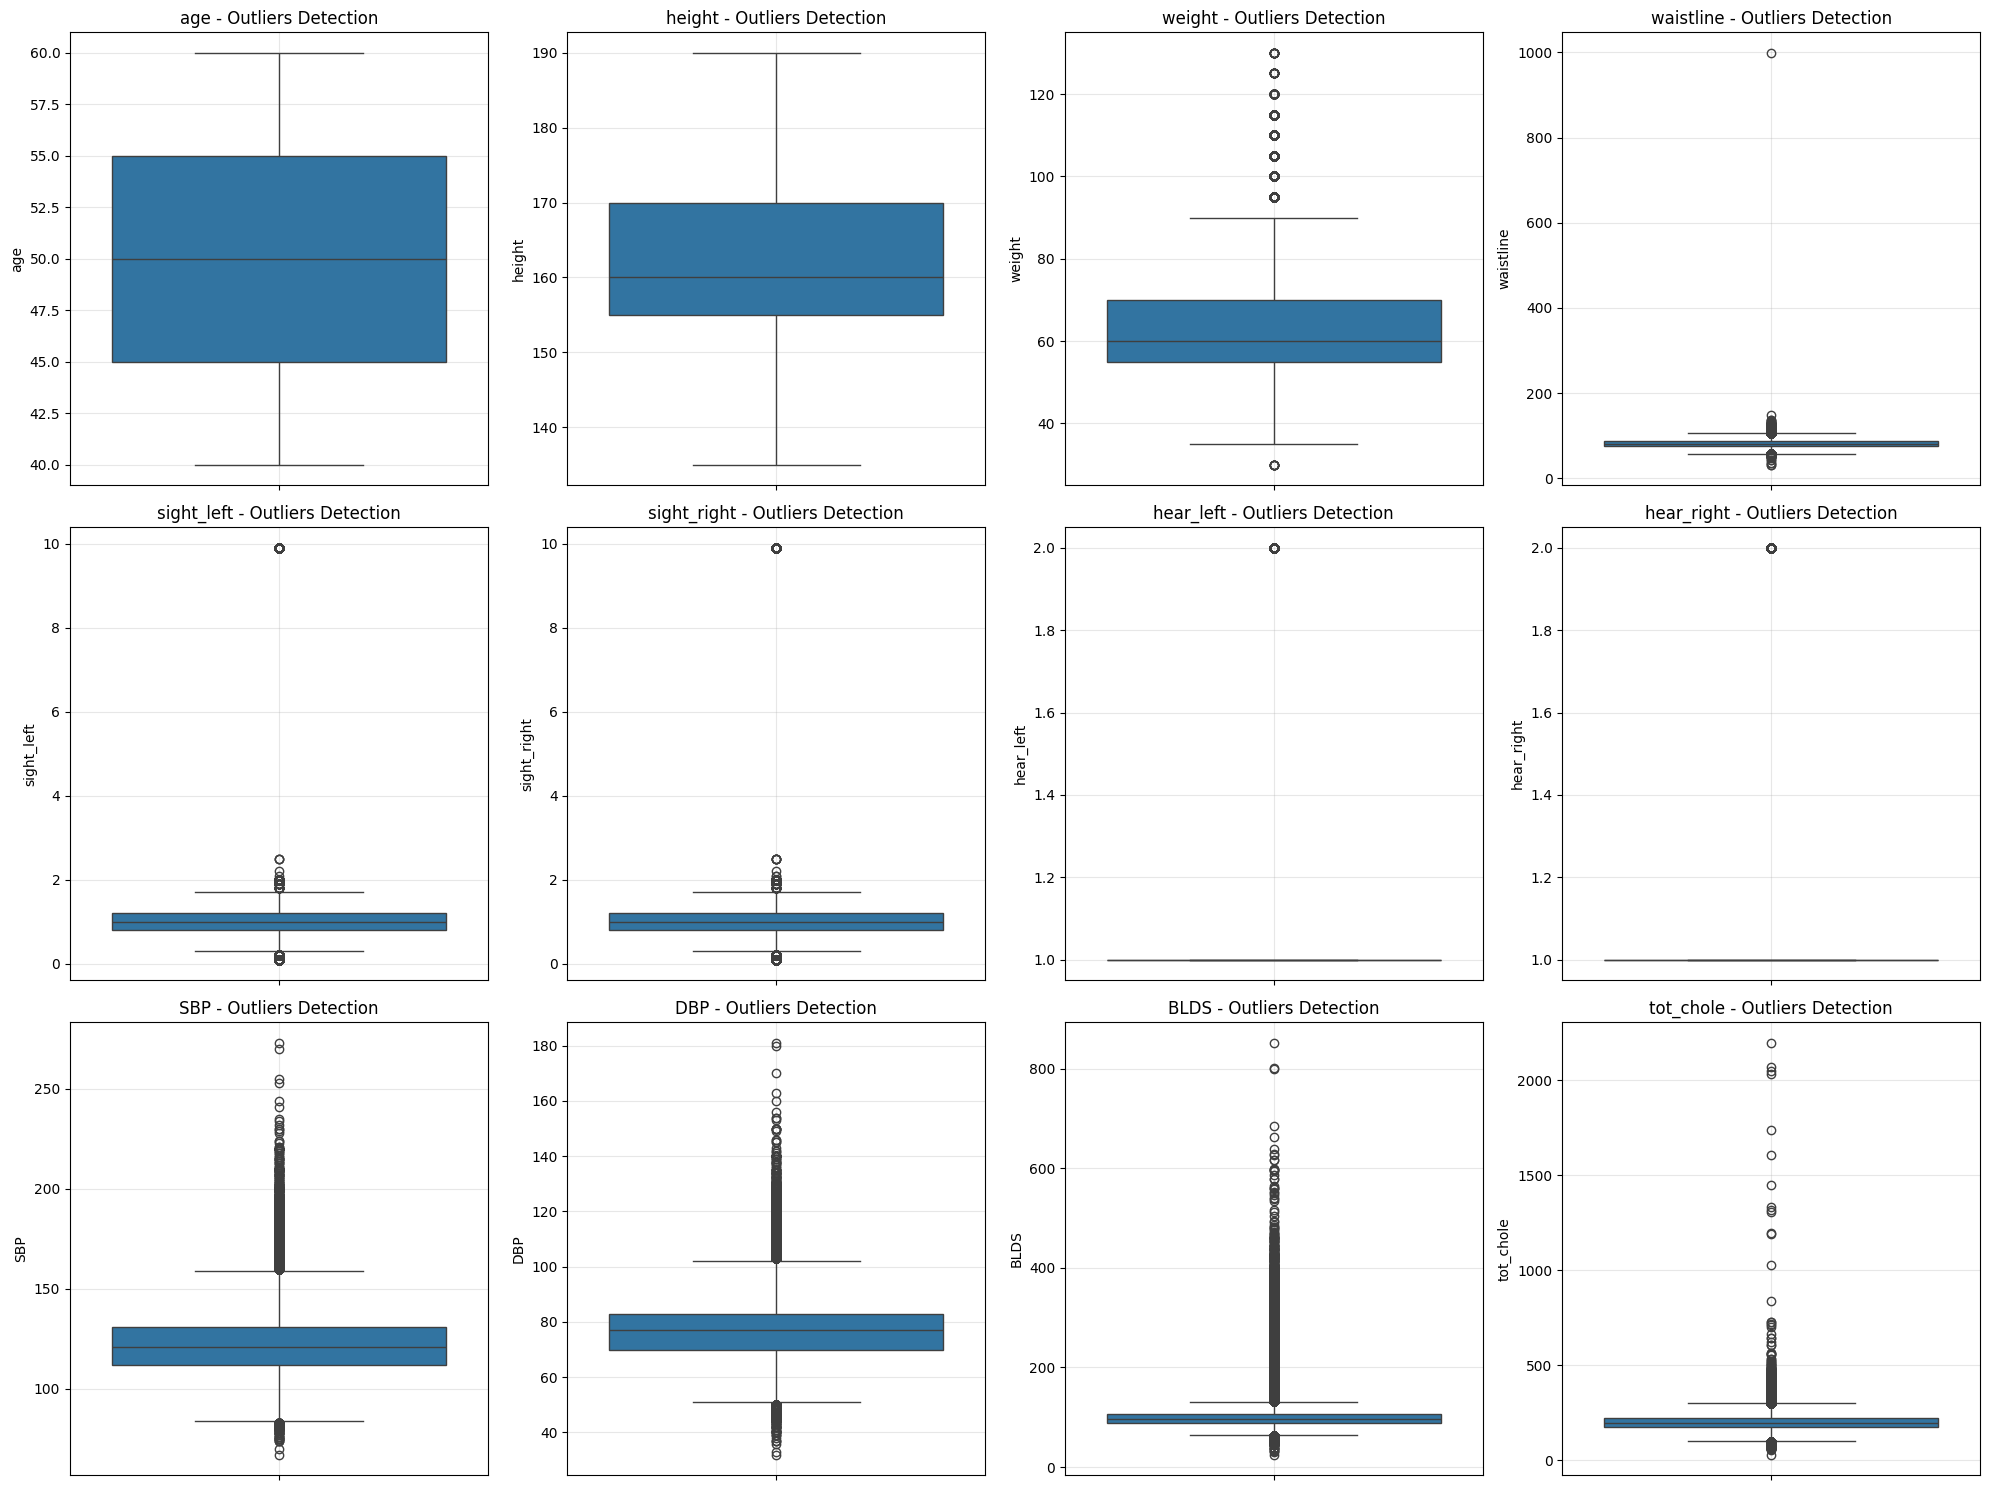

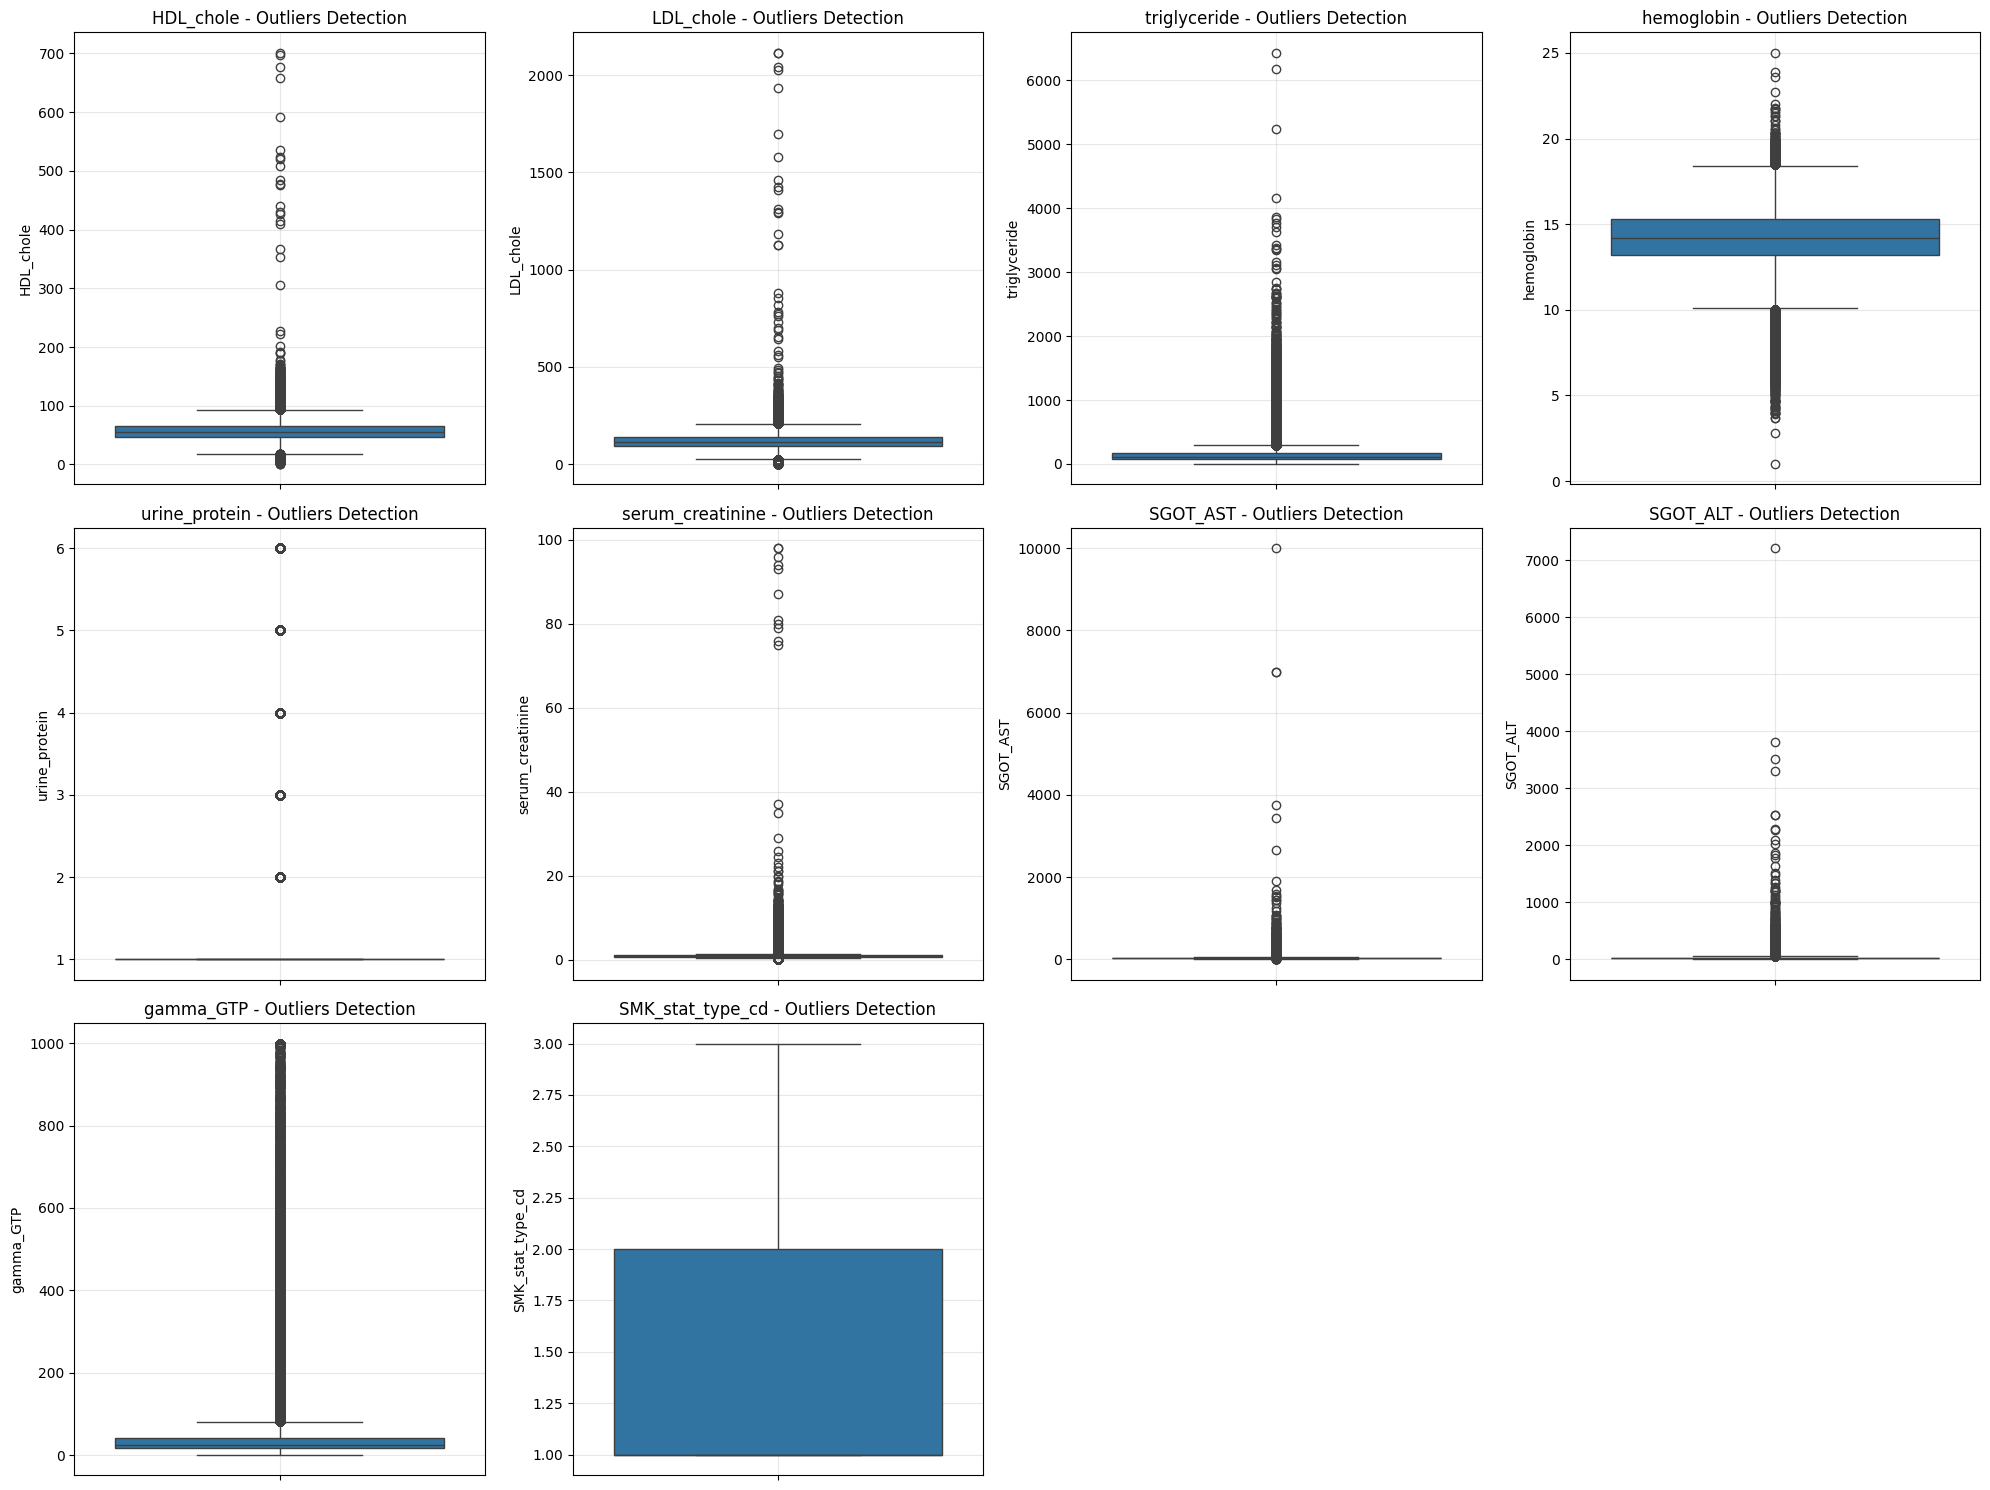

In [8]:
# Create visualizations for outliers
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(numerical_cols[:12]):  # Show first 12 numerical columns
    # Calculate outlier bounds for this column
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Create box plot
    sns.boxplot(data=df, y=col, ax=axes[i])
    axes[i].set_title(f'{col} - Outliers Detection')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create additional plots for remaining numerical columns if any
if len(numerical_cols) > 12:
    remaining_cols = numerical_cols[12:]
    n_remaining = len(remaining_cols)
    n_cols = 4
    n_rows = (n_remaining + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    if n_rows == 1:
        axes = [axes] if n_remaining == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, col in enumerate(remaining_cols):
        sns.boxplot(data=df, y=col, ax=axes[i])
        axes[i].set_title(f'{col} - Outliers Detection')
        axes[i].grid(True, alpha=0.3)
    
    # Hide empty subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

In [9]:
# --- Variable groups from dataset documentation ---
CONTINUOUS_VARS = [
    "age", "height", "weight", "sight_left", "sight_right",
    "SBP", "DBP", "BLDS", "tot_chole", "HDL_chole", "LDL_chole",
    "triglyceride", "hemoglobin", "serum_creatinine",
    "SGOT_AST", "SGOT_ALT", "gamma_GTP", "waistline"
]

ORDINAL_VARS = ["urine_protein"]  # exclude from IQR
CATEGORICAL_VARS = ["sex", "hear_left", "hear_right", "SMK_stat_type_cd", "DRK_YN"]

# Use intersection with actual columns
cont_cols = [c for c in CONTINUOUS_VARS if c in df.columns]

def iqr_bounds(s: pd.Series):
    s = pd.to_numeric(s, errors="coerce").dropna()
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    return low, high

In [10]:
# Remove (clear errors)

df_clean = df.copy()

REMOVE_RULES = {
    "waistline": lambda s: s > 200,  # e.g., 1000 cm entries
    "serum_creatinine": lambda s: s > 20,  # mg/dL, implausible highs
    "SGOT_AST": lambda s: s > 9000,  # extreme enzyme typos
    "SGOT_ALT": lambda s: s > 9000,
    "sight_left": lambda s: s >= 5,  # 10.0 eyesight entries -> remove
    "sight_right": lambda s: s >= 5,
}

# Apply removal rules
mask_keep = pd.Series(True, index=df_clean.index)
remove_report = []
for col, rule in REMOVE_RULES.items():
    if col in df_clean.columns:
        bad = rule(pd.to_numeric(df_clean[col], errors="coerce"))
        n_bad = int(bad.sum())
        if n_bad > 0:
            mask_keep &= ~bad
            remove_report.append((col, n_bad))

df_clean = df_clean.loc[mask_keep]
print("Rows removed (by column):", remove_report)

# =========================
# 2) CAP (winsorize at IQR)
# =========================
cap_report = []
for col in cont_cols:
    if col in df_clean.columns:
        low, high = iqr_bounds(df_clean[col])
        before = pd.to_numeric(df_clean[col], errors="coerce")
        n_low = int((before < low).sum())
        n_high = int((before > high).sum())
        df_clean[col] = before.clip(lower=low, upper=high)
        cap_report.append({
            "column": col,
            "capped_low": n_low,
            "capped_high": n_high
        })

print(pd.DataFrame(cap_report))

# ==============================
# 3) TRANSFORM (reduce skew with log1p)
# ==============================
LOG1P_VARS = [
    v for v in [
        "weight", "BLDS", "tot_chole", "HDL_chole", "LDL_chole",
        "triglyceride", "SGOT_AST", "SGOT_ALT", "gamma_GTP"
    ]
    if v in df_clean.columns
]

transform_report = []
for col in LOG1P_VARS:
    x = pd.to_numeric(df_clean[col], errors="coerce")
    n_neg = int((x < 0).sum())
    if n_neg:
        x = x.clip(lower=0)  # ensure non-negative before log1p
    df_clean[col] = np.log1p(x)
    transform_report.append({
        "column": col,
        "negatives_clipped": n_neg
    })

print(pd.DataFrame(transform_report))


Rows removed (by column): [('waistline', 1), ('serum_creatinine', 20), ('SGOT_AST', 1), ('sight_left', 1449), ('sight_right', 1411)]
              column  capped_low  capped_high
0                age           0            0
1             height           0            0
2             weight           8         7623
3         sight_left        9336         4503
4        sight_right        9773         3729
5                SBP         265         8440
6                DBP         536         5999
7               BLDS         835        40085
8          tot_chole         679         6102
9          HDL_chole         127        11023
10         LDL_chole         939         5506
11      triglyceride           0        33210
12        hemoglobin        7603          742
13  serum_creatinine         305         3135
14          SGOT_AST          28        34649
15          SGOT_ALT           0        39507
16         gamma_GTP           0        53676
17         waistline         345       

Data Transformation

In [11]:
import pandas as pd

# Make a copy to avoid changing the original dataset
df_encoded = df_clean.copy()

# Ordinal encoding: urine_protein (1 to 6 is ordered)
df_encoded["urine_protein"] = df_encoded["urine_protein"].astype(int)

# One-hot encoding for nominal variables
nominal_vars = ["sex", "hear_left", "hear_right", "SMK_stat_type_cd", "DRK_YN"]

df_encoded = pd.get_dummies(df_encoded, columns=nominal_vars, drop_first=True)

# Show only the newly created encoded columns
encoded_cols = [col for col in df_encoded.columns if any(var in col for var in nominal_vars)] + ["urine_protein"]
print(df_encoded[encoded_cols].head())


   sex_Male  hear_left_2.0  hear_right_2.0  SMK_stat_type_cd_2.0  \
0      True          False           False                 False   
1      True          False           False                 False   
2      True          False           False                 False   
3      True          False           False                 False   
4     False          False           False                 False   

   SMK_stat_type_cd_3.0  DRK_YN_Y  urine_protein  
0                 False     False              1  
1                 False     False              1  
2                 False     False              1  
3                  True      True              3  
4                 False     False              1  


Feature scaling

In [26]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from IPython.display import display, Markdown

# Columns to show
cols_to_show = ["age", "weight", "waistline", "SBP", "triglyceride"]

# Before scaling
summary_before = df_encoded[cols_to_show].describe().round(2)

# After scaling
scaler = StandardScaler()
df_scaled = df_encoded.copy()
df_scaled[cols_to_show] = scaler.fit_transform(df_encoded[cols_to_show])
summary_after = df_scaled[cols_to_show].describe().round(2)

# Display summaries neatly in notebook
display(Markdown("### Summary statistics before scaling"))
display(summary_before)

display(Markdown("### Summary statistics after standardization (Z-score)"))
display(summary_after)


### Summary statistics before scaling

,age,weight,waistline,SBP,triglyceride
count,592819.00,592819.00,592819.0,592819.00,592819.00
mean,49.52,4.14,81.2,122.33,4.73
std,7.01,0.18,9.1,13.89,0.53
min,40.00,3.51,57.0,83.50,0.69
25%,45.00,4.03,75.0,112.00,4.36
50%,50.00,4.11,81.0,121.00,4.72
75%,55.00,4.26,87.0,131.00,5.11
max,60.00,4.54,105.0,159.50,5.70


### Summary statistics after standardization (Z-score)

,age,weight,waistline,SBP,triglyceride
count,592819.00,592819.00,592819.00,592819.00,592819.00
mean,0.00,0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00
min,-1.36,-3.51,-2.66,-2.80,-7.64
25%,-0.64,-0.66,-0.68,-0.74,-0.71
50%,0.07,-0.19,-0.02,-0.10,-0.03
75%,0.78,0.65,0.64,0.62,0.71
max,1.50,2.18,2.62,2.68,1.82


Data splitting

In [29]:
df_split = df_scaled.copy()

# Set 'DRK_YN'(Drinker or Not) as target variable
X = df_split.drop('DRK_YN_Y', axis=1)
y = df_split['DRK_YN_Y']

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape (X_train):", X_train.shape)
print("Testing set shape (X_test):", X_test.shape)
print("Training set shape (y_train):", y_train.shape)
print("Testing set shape (y_test):", y_test.shape)

Training set shape (X_train): (474255, 24)
Testing set shape (X_test): (118564, 24)
Training set shape (y_train): (474255,)
Testing set shape (y_test): (118564,)


# Feature extracting

SGOT_AST            165.738259
serum_creatinine    112.288906
SGOT_ALT             60.296041
sight_right          10.750844
sight_left           10.681968
gamma_GTP             7.402068
hear_right            6.635844
hear_left             6.515628
triglyceride          5.980332
urine_protein         5.755595
BLDS                  4.461389
LDL_chole             2.516334
waistline             1.811748
HDL_chole             1.785216
tot_chole             1.596834
SMK_stat_type_cd      0.781870
weight                0.492069
SBP                   0.463492
DBP                   0.378413
age                   0.077789
height                0.058596
hemoglobin           -0.441448
dtype: float64
Highly skewed features: ['SGOT_AST', 'serum_creatinine', 'SGOT_ALT', 'sight_right', 'sight_left', 'gamma_GTP', 'hear_right', 'hear_left', 'triglyceride', 'urine_protein', 'BLDS', 'LDL_chole', 'waistline', 'HDL_chole', 'tot_chole']


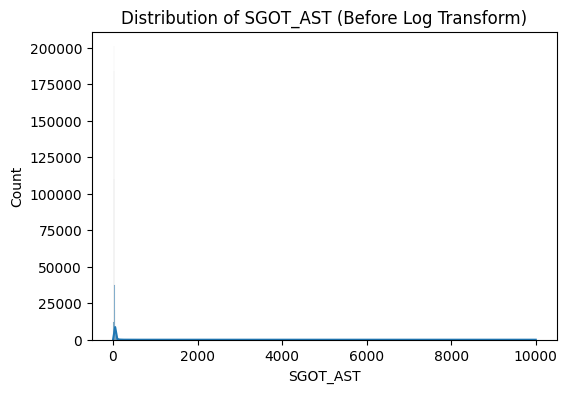

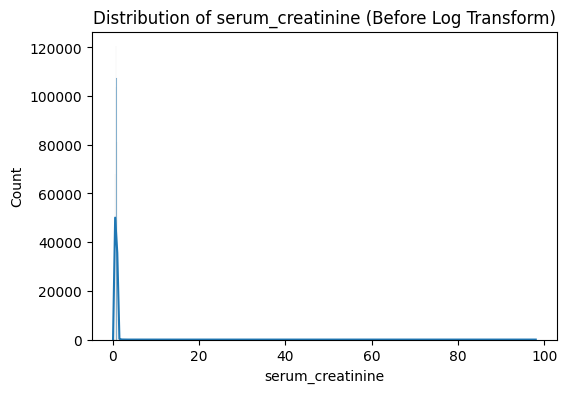

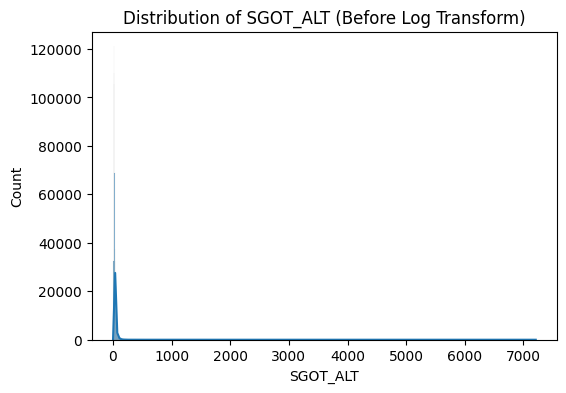

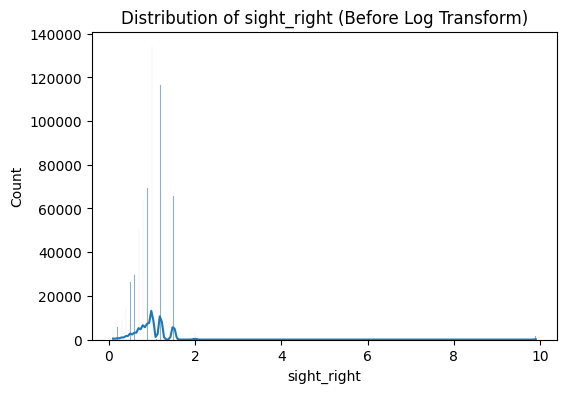

In [13]:
# Numerical features only
num_cols = df.select_dtypes(include=[np.number]).columns

# Compute skewness
skew_vals = df[num_cols].skew().sort_values(ascending=False)
print(skew_vals)

# Visualize highly skewed features (top 4 for example)
high_skew = skew_vals[skew_vals > 1].index.tolist()
print("Highly skewed features:", high_skew)

for col in high_skew[:4]:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col} (Before Log Transform)")
    plt.show()

Skewness after log transform:
hear_right          6.635844
hear_left           6.515628
urine_protein       4.840889
serum_creatinine    3.021519
BLDS                2.034012
SGOT_AST            1.482175
sight_left          1.447070
sight_right         1.406086
gamma_GTP           0.987817
SGOT_ALT            0.774939
triglyceride        0.405478
HDL_chole          -0.029394
waistline          -0.112067
tot_chole          -0.266684
LDL_chole          -1.090736
dtype: float64


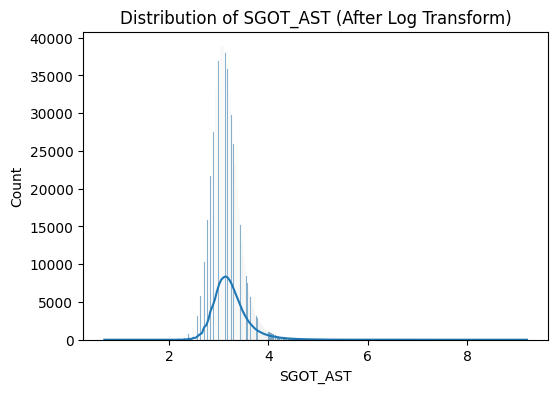

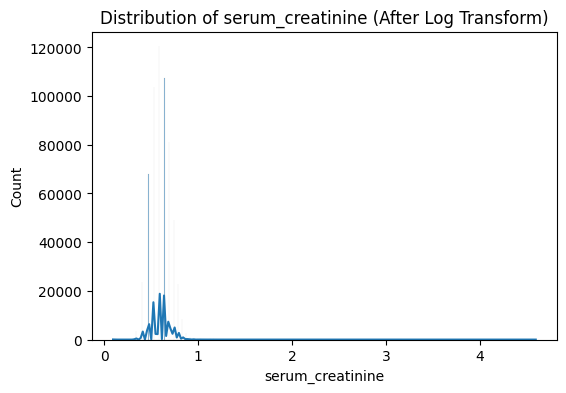

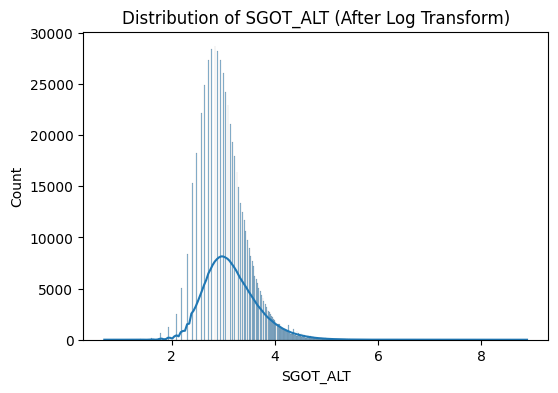

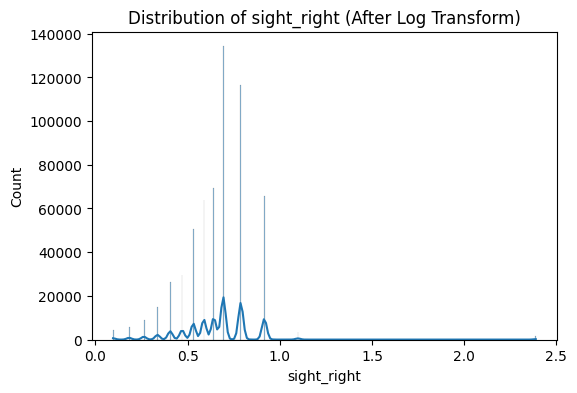

In [14]:
# Apply log1p to highly skewed features
for col in high_skew:
    df[col] = np.log1p(df[col])

# Recompute skewness after transformation
skew_after = df[high_skew].skew().sort_values(ascending=False)
print("Skewness after log transform:")
print(skew_after)

# Optional visualization after
for col in high_skew[:4]:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col} (After Log Transform)")
    plt.show()

Feature extraction after stabilizing data:

In [15]:
df['BMI'] = df['weight'] / (df['height']/100)**2
df['pulse_pressure'] = df['SBP'] - df['DBP']
df['LDL_to_HDL'] = df['LDL_chole'] / df['HDL_chole']
df['TG_to_HDL'] = df['triglyceride'] / df['HDL_chole']
df['sight_avg'] = (df['sight_left'] + df['sight_right']) / 2
df['hearing_avg'] = (df['hear_left'] + df['hear_right']) / 2